# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from keras.datasets import mnist

# Neural Network from Scratch

In [2]:
def init_params():
    W1 = np.random.randn(128, 784) * 0.01
    b1 = np.zeros((128, 1))
    W2 = np.random.randn(10, 128) * 0.01
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0))  # Ensure numerical stability
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    m = Y.size
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 100 == 0:
            predictions = get_predictions(A2)
            print(f"Iteration {i}: Accuracy {get_accuracy(predictions, Y)}")
    
    return W1, b1, W2, b2

# Load MNIST dataset

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784).T / 255.0
X_test = X_test.reshape(X_test.shape[0], 784).T / 255.0
Y_train = Y_train.T
Y_test = Y_test.T

# Train the model

In [4]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 1000)

Iteration 0: Accuracy 0.10213333333333334
Iteration 100: Accuracy 0.7867333333333333
Iteration 200: Accuracy 0.8661666666666666
Iteration 300: Accuracy 0.8879666666666667
Iteration 400: Accuracy 0.8983666666666666
Iteration 500: Accuracy 0.9046833333333333
Iteration 600: Accuracy 0.90955
Iteration 700: Accuracy 0.91385
Iteration 800: Accuracy 0.9174666666666667
Iteration 900: Accuracy 0.9200666666666667


# Predict

Prediction: [5], Label: 5


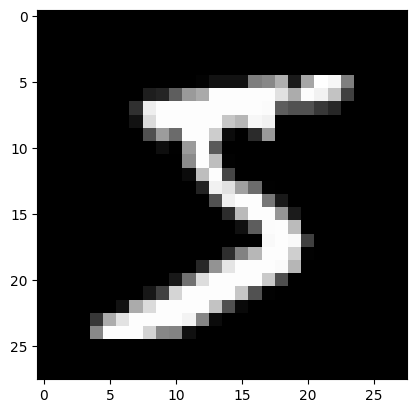

In [5]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    label = Y_train[index]
    print(f"Prediction: {prediction}, Label: {label}")
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

test_prediction(0, W1, b1, W2, b2)

# PyTorch Implementation

In [6]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Load data into PyTorch tensors and Initialize model, loss, and optimizer

In [7]:
X_train_torch = torch.from_numpy(X_train.T).float()
Y_train_torch = torch.from_numpy(Y_train).long()
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the PyTorch model

In [8]:
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, Y_train_torch)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == Y_train_torch).sum().item() / Y_train_torch.size(0)
        print(f'Epoch {epoch}: Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch 0: Loss: 2.3062, Accuracy: 0.0813
Epoch 100: Loss: 0.2920, Accuracy: 0.9193
Epoch 200: Loss: 0.1941, Accuracy: 0.9463
Epoch 300: Loss: 0.1386, Accuracy: 0.9621
Epoch 400: Loss: 0.1033, Accuracy: 0.9714
